<a href="https://colab.research.google.com/github/chikhaliap10/CS668/blob/main/CS668_Inventory_Management_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [5]:
!git clone https://github.com/chikhaliap10/CS668.git

fatal: destination path 'CS668' already exists and is not an empty directory.


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [42]:
# USING LOCAL FILE V2
data = pd.read_excel("./CS668/Online Retail 3.xlsx")

print("First few rows of the dataset:")
print(data.head())

print("\nData Info:")
print(data.info())

print("\nStatistical Summary:")
print(data.describe())

First few rows of the dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   D

In [43]:
# PRE-PROCESSING the DATA
# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


In [44]:
print("\nUnique Counts of Categorical Columns:")
for col in ['InvoiceNo', 'StockCode', 'Description', 'Country']:
    print(f"{col}: {data[col].nunique()} unique values")

print("\nData Types and Null Values:")
print(data.dtypes)
print("\nMissing Values in Each Column:")
print(data.isnull().sum())



Unique Counts of Categorical Columns:
InvoiceNo: 25900 unique values
StockCode: 4070 unique values
Description: 4223 unique values
Country: 38 unique values

Data Types and Null Values:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Missing Values in Each Column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [46]:
print("\nColumns with Missing Values:")
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

data_cleaned = data.dropna(subset=['CustomerID', 'Description'])
print(f"\nShape of Data After Dropping Missing Values: {data_cleaned.shape}")



Columns with Missing Values:
Description      1454
CustomerID     135080
dtype: int64

Shape of Data After Dropping Missing Values: (406829, 8)


In [47]:
duplicates_count = data_cleaned.duplicated().sum()
print(f"\nNumber of Duplicate Rows Before Removal: {duplicates_count}")

data_cleaned = data_cleaned.drop_duplicates()
print(f"Shape of Data After Dropping Duplicates: {data_cleaned.shape}")



Number of Duplicate Rows Before Removal: 5225
Shape of Data After Dropping Duplicates: (401604, 8)


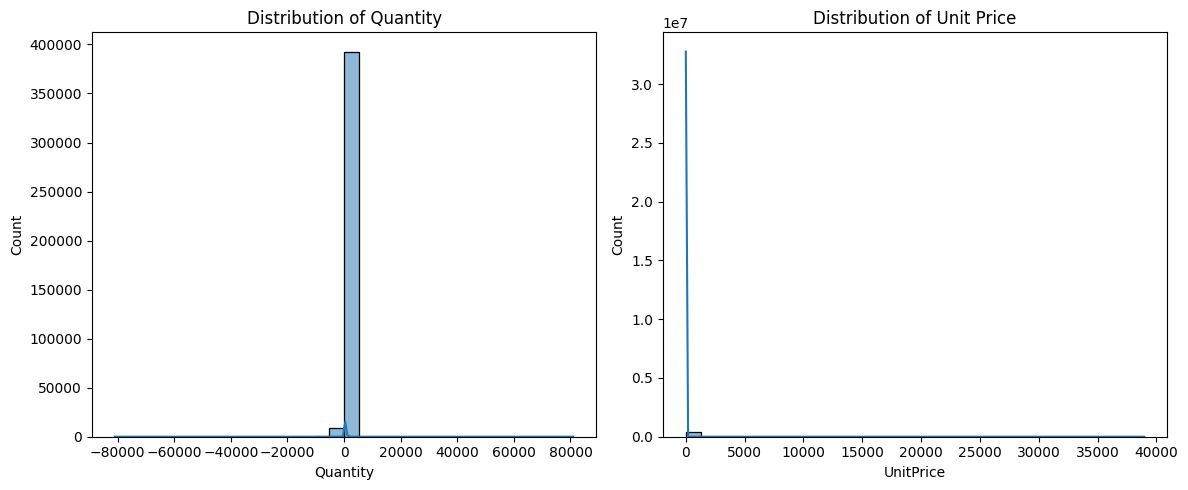

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data_cleaned['Quantity'], bins=30, kde=True)
plt.title("Distribution of Quantity")

plt.subplot(1, 2, 2)
sns.histplot(data_cleaned['UnitPrice'], bins=30, kde=True)
plt.title("Distribution of Unit Price")

plt.tight_layout()
plt.show()


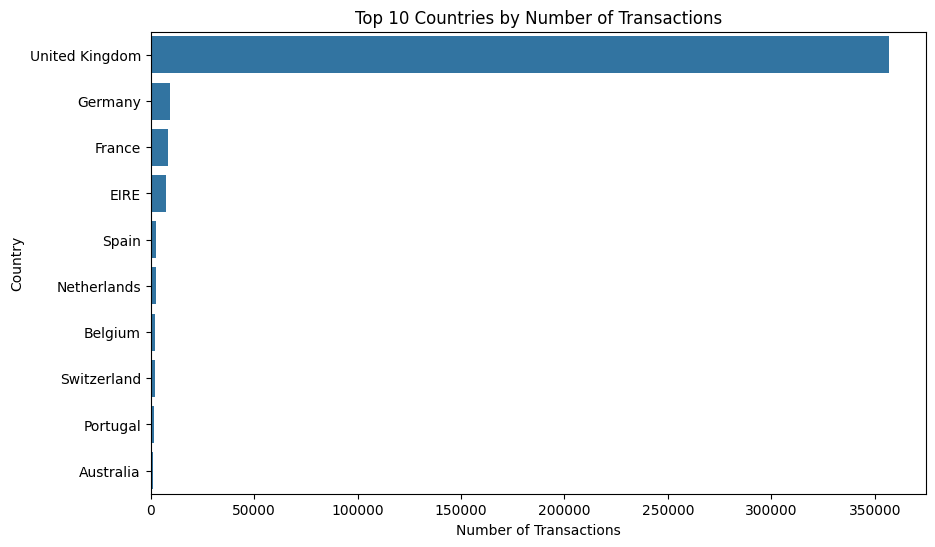

In [49]:
plt.figure(figsize=(10, 6))
country_counts = data_cleaned['Country'].value_counts().head(10)
sns.barplot(x=country_counts.values, y=country_counts.index)
plt.title("Top 10 Countries by Number of Transactions")
plt.xlabel("Number of Transactions")
plt.show()


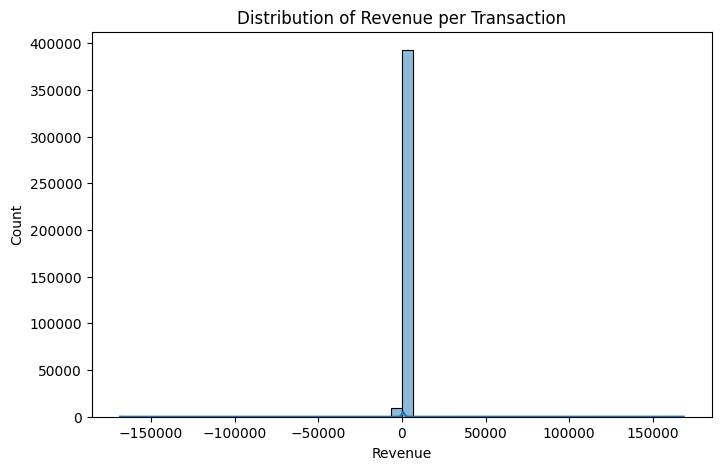

In [50]:
data_cleaned['Revenue'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']

plt.figure(figsize=(8, 5))
sns.histplot(data_cleaned['Revenue'], bins=50, kde=True)
plt.title("Distribution of Revenue per Transaction")
plt.xlabel("Revenue")
plt.show()


**Q1: What factors influence purchasing behavior for different product categories in an online retail environment?**

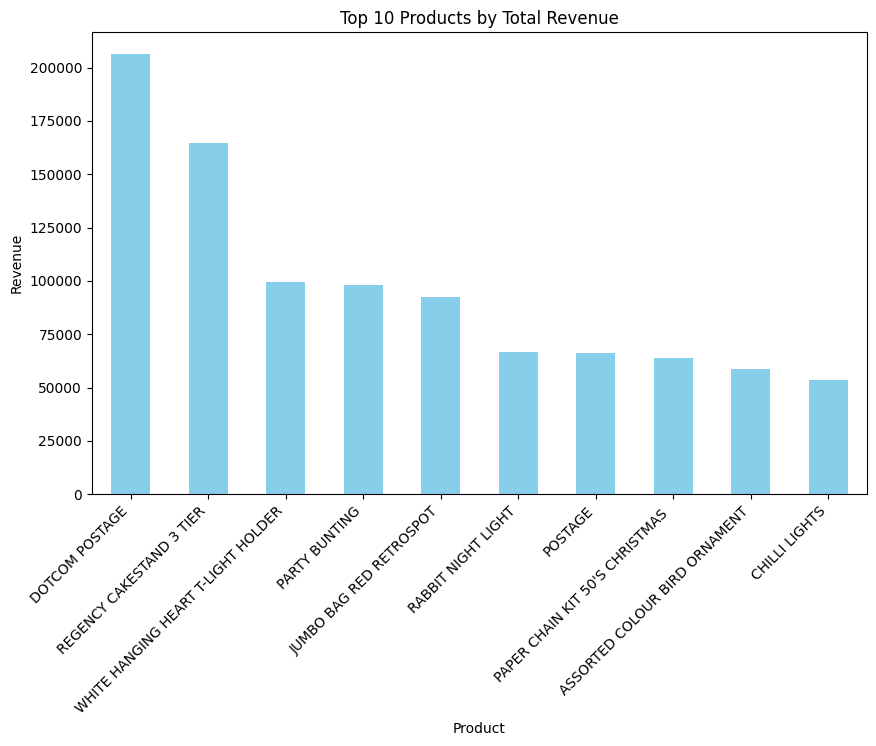

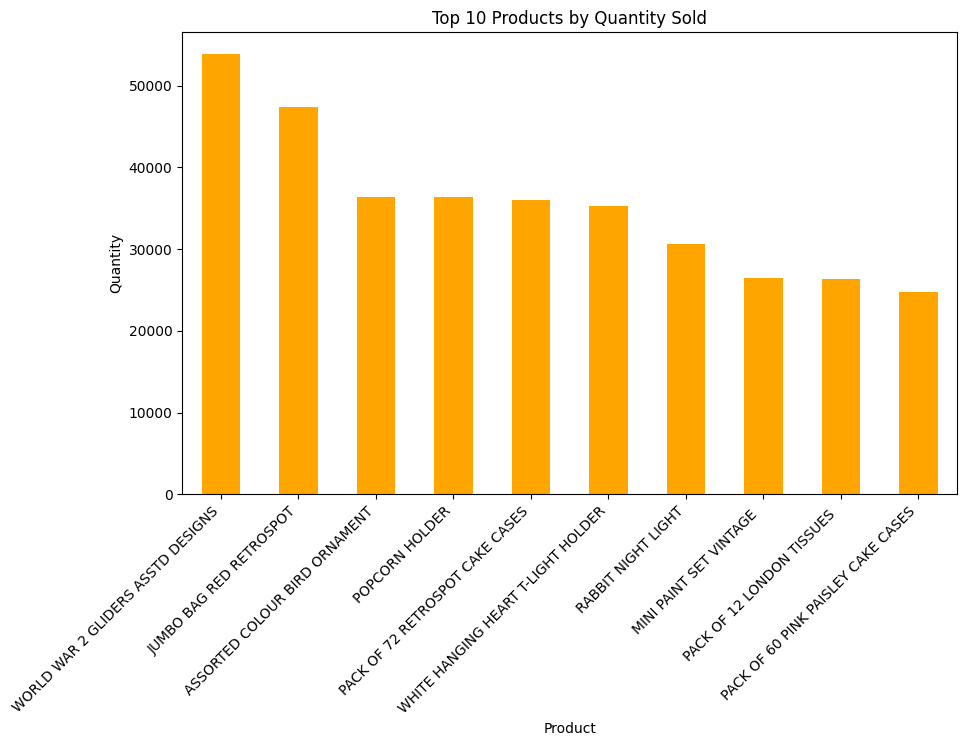

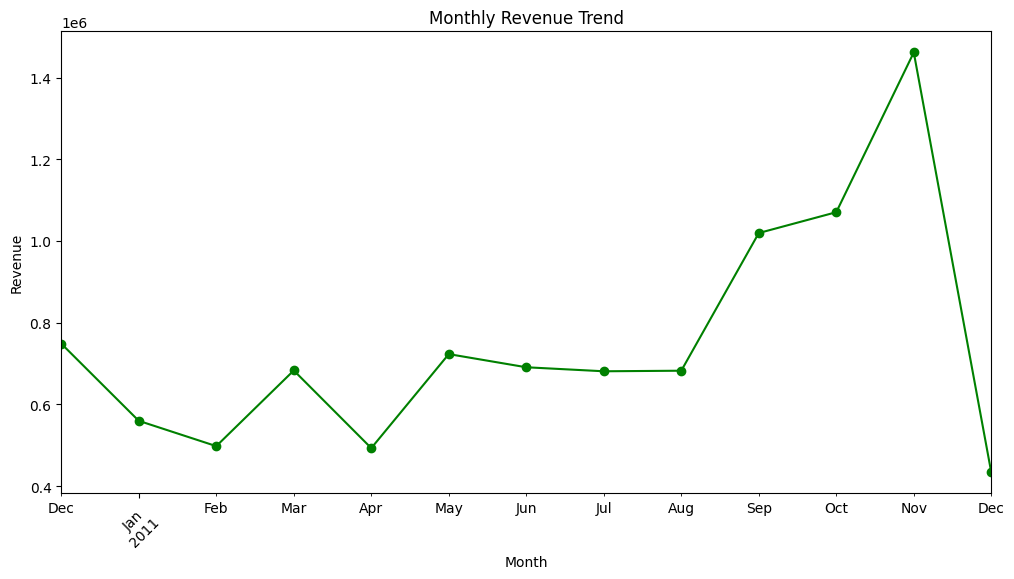

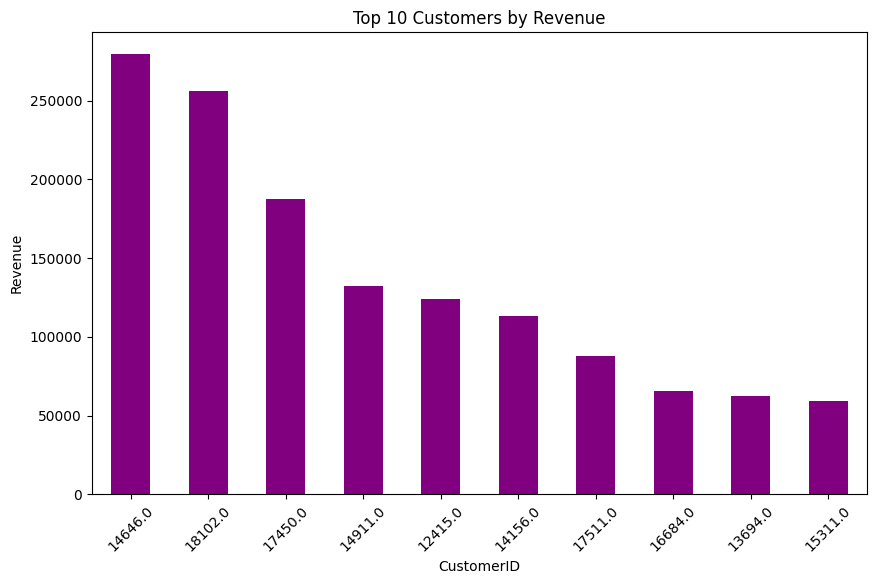

In [51]:
# 1. Total Revenue by Product
data['TotalRevenue'] = data['Quantity'] * data['UnitPrice']
product_revenue = data.groupby('Description')['TotalRevenue'].sum().sort_values(ascending=False).head(10)

# Plot top 10 products by revenue
plt.figure(figsize=(10, 6))
product_revenue.plot(kind='bar', color='skyblue')
plt.title('Top 10 Products by Total Revenue')
plt.ylabel('Revenue')
plt.xlabel('Product')
plt.xticks(rotation=45, ha='right')
plt.show()

# 2. Quantity Sold by Product
product_quantity = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Plot top 10 products by quantity sold
plt.figure(figsize=(10, 6))
product_quantity.plot(kind='bar', color='orange')
plt.title('Top 10 Products by Quantity Sold')
plt.ylabel('Quantity')
plt.xlabel('Product')
plt.xticks(rotation=45, ha='right')
plt.show()

# 3. Seasonality Analysis (Monthly revenue trend for all products)
data['Month'] = data['InvoiceDate'].dt.to_period('M')
monthly_revenue = data.groupby('Month')['TotalRevenue'].sum()

# Plot monthly revenue trend
plt.figure(figsize=(12, 6))
monthly_revenue.plot(kind='line', marker='o', color='green')
plt.title('Monthly Revenue Trend')
plt.ylabel('Revenue')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

# 4. Customer Segmentation by Revenue
customer_revenue = data.groupby('CustomerID')['TotalRevenue'].sum().sort_values(ascending=False).head(10)

# Plot top 10 customers by revenue
plt.figure(figsize=(10, 6))
customer_revenue.plot(kind='bar', color='purple')
plt.title('Top 10 Customers by Revenue')
plt.ylabel('Revenue')
plt.xlabel('CustomerID')
plt.xticks(rotation=45)
plt.show()

**Q2: Can we predict future sales trends using historical transactional data to optimize stock levels?**

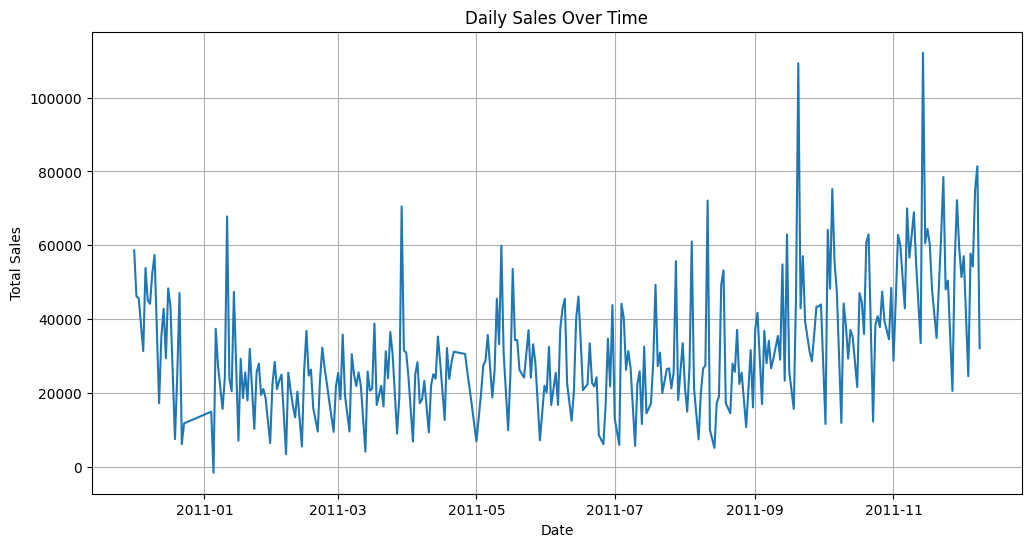

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean Squared Error (Non-seasonal): 395977570.64038306


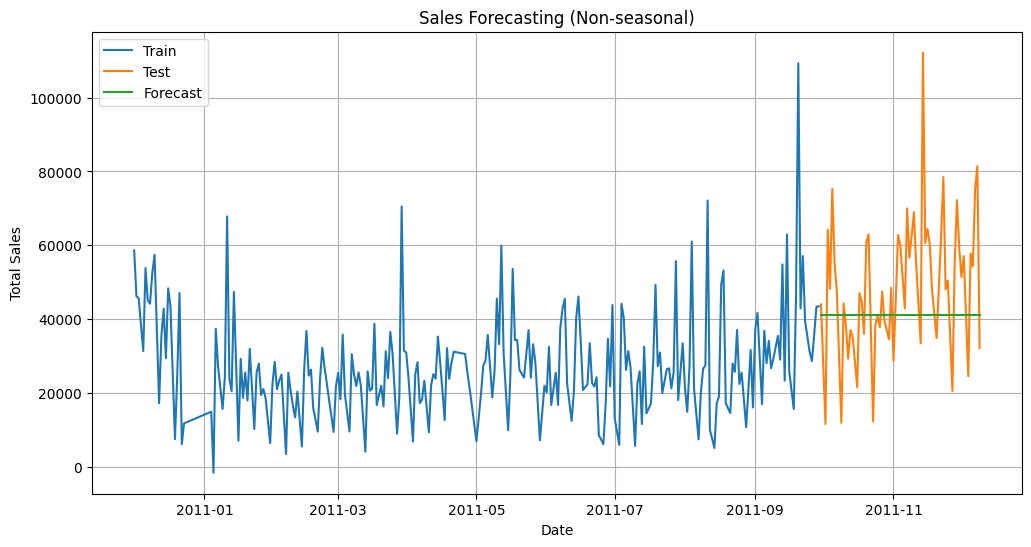

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Mean Squared Error (Seasonal): 14441773501.74146


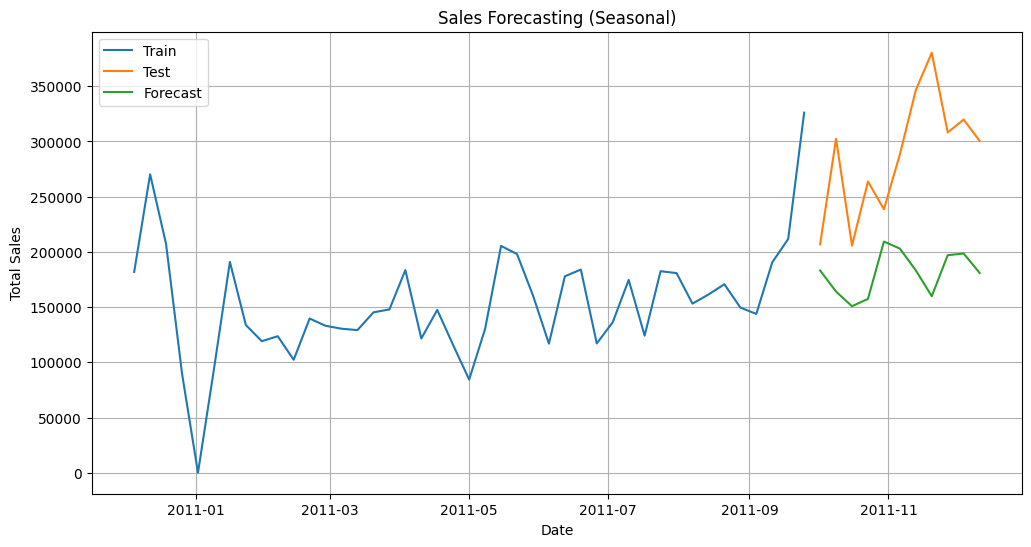

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Mean Squared Error (ARIMA): 8325019089.892019


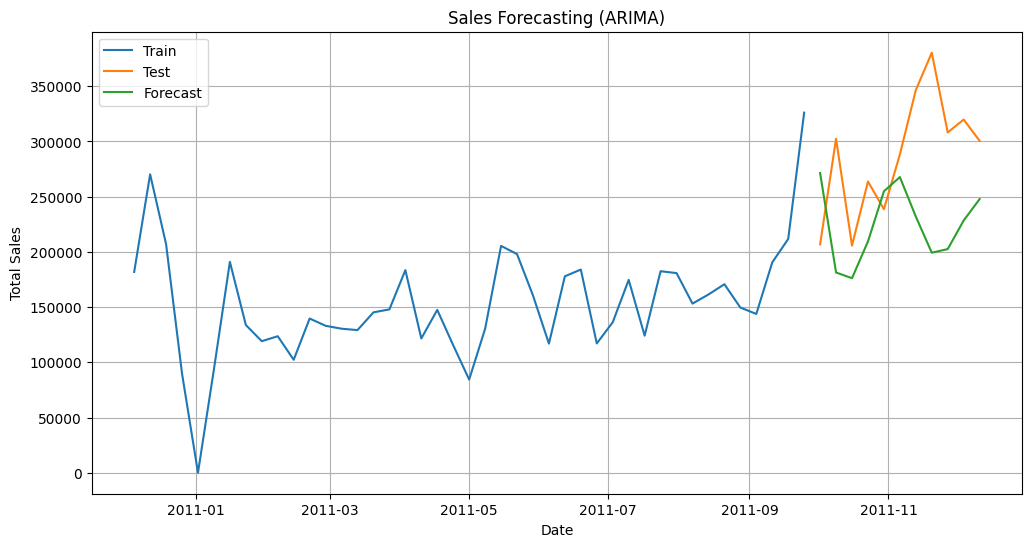

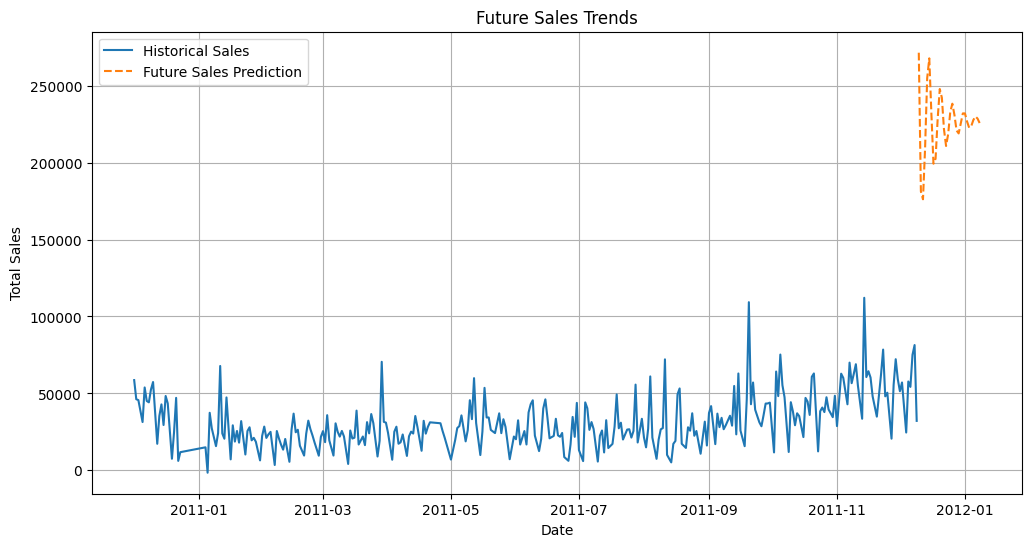

                 Date  PredictedSales
2011-10-02 2011-12-10   271441.577333
2011-10-09 2011-12-11   181340.927499
2011-10-16 2011-12-12   176182.798925
2011-10-23 2011-12-13   209439.231607
2011-10-30 2011-12-14   254903.814118
2011-11-06 2011-12-15   267788.709287
2011-11-13 2011-12-16   232008.285717
2011-11-20 2011-12-17   199290.454392
2011-11-27 2011-12-18   202547.657265
2011-12-04 2011-12-19   228460.929516
2011-12-11 2011-12-20   247847.606944
2011-12-18 2011-12-21   242214.379049
2011-12-25 2011-12-22   221741.521570
2012-01-01 2011-12-23   210828.722165
2012-01-08 2011-12-24   218479.176284
2012-01-15 2011-12-25   232946.151140
2012-01-22 2011-12-26   238311.986292
2012-01-29 2011-12-27   230944.771517
2012-02-05 2011-12-28   220903.221675
2012-02-12 2011-12-29   218983.303542
2012-02-19 2011-12-30   225445.538008
2012-02-26 2011-12-31   231999.441630
2012-03-04 2012-01-01   231985.911769
2012-03-11 2012-01-02   226760.209470
2012-03-18 2012-01-03   222698.054753
2012-03-25 2

In [52]:
# Preprocessing
data['TotalSales'] = data['Quantity'] * data['UnitPrice']

# Aggregate data at the daily level
daily_sales = data.groupby(data['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
daily_sales.columns = ['Date', 'TotalSales']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])
daily_sales.set_index('Date', inplace=True)

# Visualize sales trends
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['TotalSales'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid()
plt.show()

# Train-test split
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

# Option 1: Non-seasonal Exponential Smoothing
try:
    model = ExponentialSmoothing(train['TotalSales'], seasonal=None).fit()
    predictions = model.forecast(len(test))

    # Evaluate the model
    mse = mean_squared_error(test['TotalSales'], predictions)
    print(f"Mean Squared Error (Non-seasonal): {mse}")

    # Visualize predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['TotalSales'], label='Train')
    plt.plot(test.index, test['TotalSales'], label='Test')
    plt.plot(test.index, predictions, label='Forecast')
    plt.title('Sales Forecasting (Non-seasonal)')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid()
    plt.show()
except Exception as e:
    print(f"Error with Non-seasonal model: {e}")

# Option 2: Weekly Aggregation for Seasonal Model
try:
    weekly_sales = data.groupby(pd.Grouper(key='InvoiceDate', freq='W'))['TotalSales'].sum().reset_index()
    weekly_sales.set_index('InvoiceDate', inplace=True)

    # Train-test split
    train_size = int(len(weekly_sales) * 0.8)
    train, test = weekly_sales[:train_size], weekly_sales[train_size:]

    # Apply Seasonal Exponential Smoothing
    model = ExponentialSmoothing(train['TotalSales'], seasonal='add', seasonal_periods=12).fit()
    predictions = model.forecast(len(test))

    # Evaluate the model
    mse = mean_squared_error(test['TotalSales'], predictions)
    print(f"Mean Squared Error (Seasonal): {mse}")

    # Visualize predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['TotalSales'], label='Train')
    plt.plot(test.index, test['TotalSales'], label='Test')
    plt.plot(test.index, predictions, label='Forecast')
    plt.title('Sales Forecasting (Seasonal)')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid()
    plt.show()
except Exception as e:
    print(f"Error with Seasonal model: {e}")

# Option 3: ARIMA Model
try:
    model = ARIMA(train['TotalSales'], order=(5, 1, 0))  # Adjust (p, d, q) based on data
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
    # Evaluate the model
    mse = mean_squared_error(test['TotalSales'], predictions)
    print(f"Mean Squared Error (ARIMA): {mse}")

    # Visualize predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['TotalSales'], label='Train')
    plt.plot(test.index, test['TotalSales'], label='Test')
    plt.plot(test.index, predictions, label='Forecast')
    plt.title('Sales Forecasting (ARIMA)')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid()
    plt.show()
except Exception as e:
    print(f"Error with ARIMA model: {e}")

# Option 4: Future Predictions with Best Model
# Using the non-seasonal model as an example (replace with your chosen model)
try:
    future_days = 30
    future_predictions = model_fit.forecast(future_days)

    # Plot future predictions
    future_dates = pd.date_range(start=daily_sales.index[-1], periods=future_days + 1, freq='D')[1:]
    plt.figure(figsize=(12, 6))
    plt.plot(daily_sales.index, daily_sales['TotalSales'], label='Historical Sales')
    plt.plot(future_dates, future_predictions, label='Future Sales Prediction', linestyle='--')
    plt.title('Future Sales Trends')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid()
    plt.show()

    # Print future predictions
    future_sales = pd.DataFrame({'Date': future_dates, 'PredictedSales': future_predictions})
    print(future_sales)
except Exception as e:
    print(f"Error with Future Predictions: {e}")

**Q3: How do seasonal patterns and holidays affect sales, and how can this data be used to improve inventory planning?**

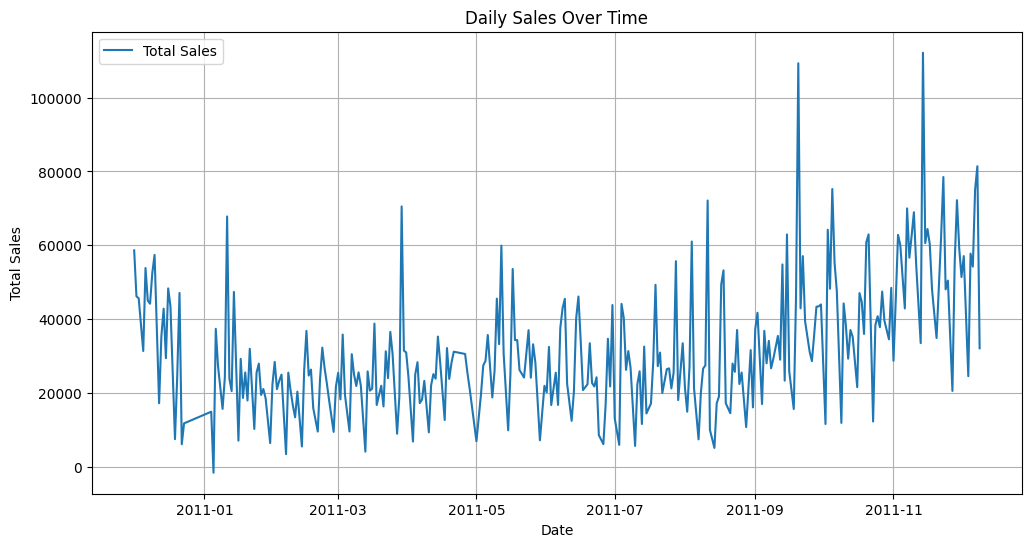

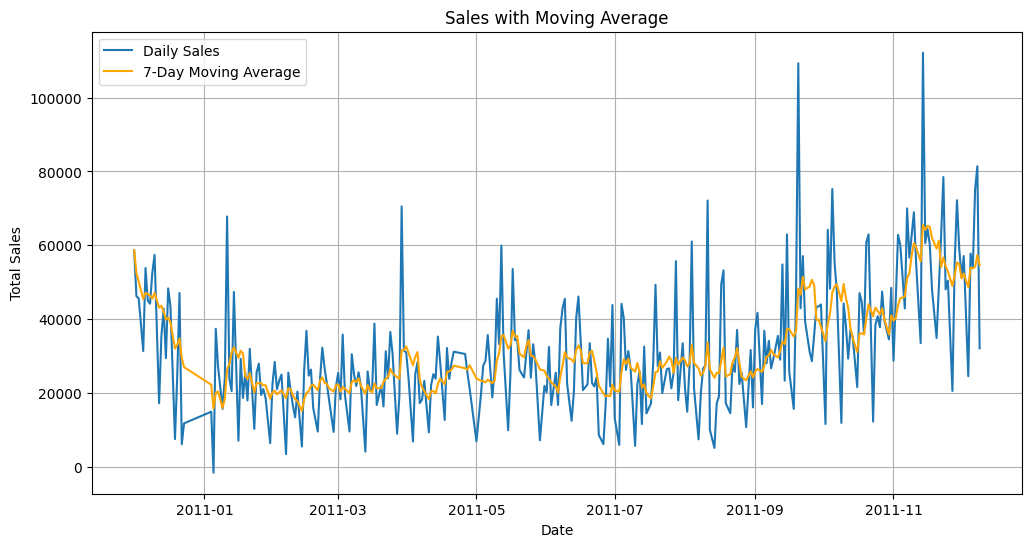

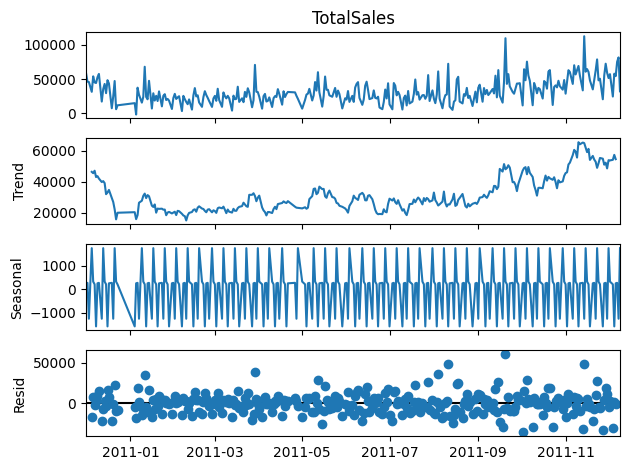

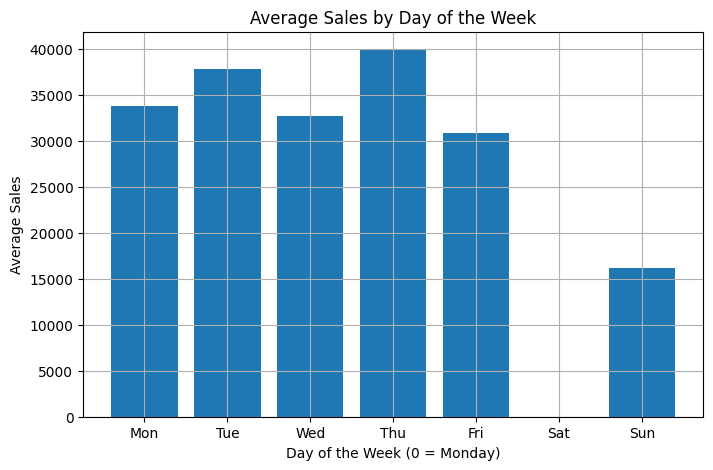

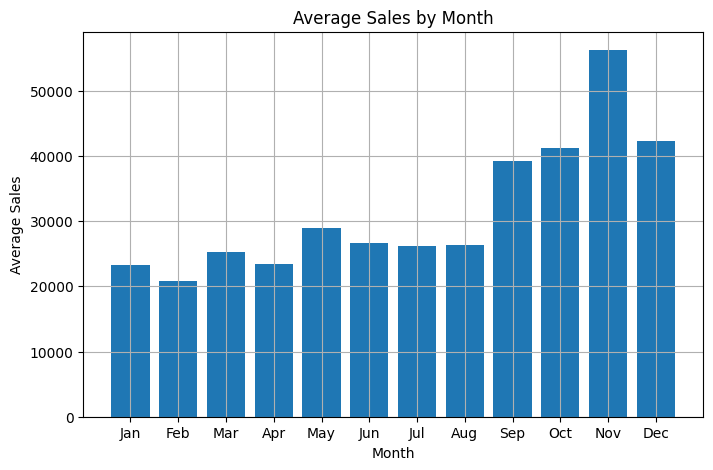

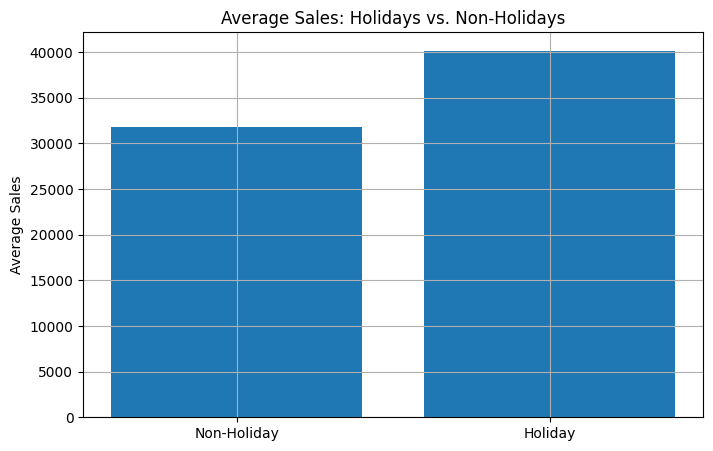

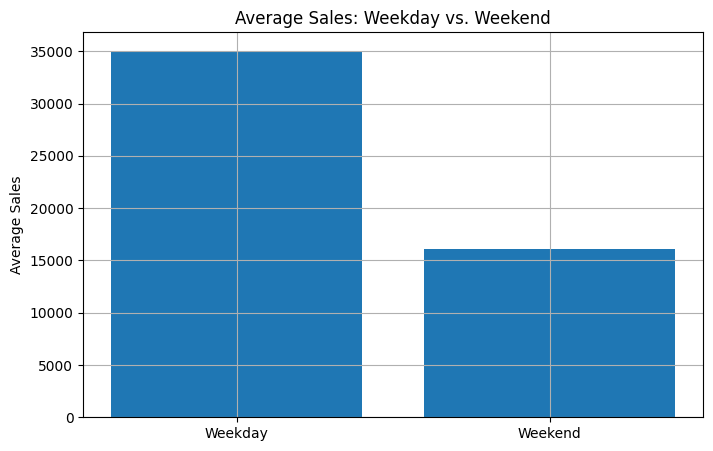

Weekly Trends:
 DayOfWeek
0    33800.200660
1    37811.207519
2    32719.754906
3    39858.849057
4    30812.216220
6    16113.577820
Name: TotalSales, dtype: float64

Monthly Trends:
 Month
1     23333.344167
2     20752.610417
3     25306.188148
4     23486.053381
5     28933.340400
6     26581.658462
7     26203.850423
8     26256.942692
9     39218.754692
10    41180.948846
11    56221.394231
12    42236.608214
Name: TotalSales, dtype: float64

Holiday Impact on Sales:
 IsHoliday
False    31766.790718
True     40177.757143
Name: TotalSales, dtype: float64

Weekend vs. Weekday Sales:
 IsWeekend
False    35066.937424
True     16113.577820
Name: TotalSales, dtype: float64


In [53]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregate data at the daily level
daily_sales = data.groupby(data['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
daily_sales.columns = ['Date', 'TotalSales']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])
daily_sales.set_index('Date', inplace=True)

# Add seasonal and holiday features
daily_sales['DayOfWeek'] = daily_sales.index.dayofweek  # 0 = Monday, 6 = Sunday
daily_sales['Month'] = daily_sales.index.month
daily_sales['IsWeekend'] = daily_sales['DayOfWeek'].isin([5, 6])  # 5 = Saturday, 6 = Sunday

# Add holiday indicator
cal = calendar()
holidays = cal.holidays(start=daily_sales.index.min(), end=daily_sales.index.max())
daily_sales['IsHoliday'] = daily_sales.index.isin(holidays)

# Visualize sales over time
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['TotalSales'], label='Total Sales')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid()
plt.legend()
plt.show()

# Moving Average to Identify Trends
daily_sales['MovingAverage'] = daily_sales['TotalSales'].rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['TotalSales'], label='Daily Sales')
plt.plot(daily_sales.index, daily_sales['MovingAverage'], label='7-Day Moving Average', color='orange')
plt.title('Sales with Moving Average')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid()
plt.show()

# Decompose if enough data is available
try:
    decomposition = seasonal_decompose(daily_sales['TotalSales'], model='additive', period=7)  # Weekly seasonality
    decomposition.plot()
    plt.show()
except ValueError as e:
    print(f"Decomposition not possible: {e}")

# Analyze weekly trends
weekly_trends = daily_sales.groupby('DayOfWeek')['TotalSales'].mean()
plt.figure(figsize=(8, 5))
plt.bar(weekly_trends.index, weekly_trends)
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week (0 = Monday)')
plt.ylabel('Average Sales')
plt.grid()
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Analyze monthly trends
monthly_trends = daily_sales.groupby('Month')['TotalSales'].mean()
plt.figure(figsize=(8, 5))
plt.bar(monthly_trends.index, monthly_trends)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.grid()
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Compare sales on holidays vs. non-holidays
holiday_sales = daily_sales.groupby('IsHoliday')['TotalSales'].mean()
plt.figure(figsize=(8, 5))
plt.bar(['Non-Holiday', 'Holiday'], holiday_sales)
plt.title('Average Sales: Holidays vs. Non-Holidays')
plt.ylabel('Average Sales')
plt.grid()
plt.show()

# Weekend vs. Weekday sales
weekend_sales = daily_sales.groupby('IsWeekend')['TotalSales'].mean()
plt.figure(figsize=(8, 5))
plt.bar(['Weekday', 'Weekend'], weekend_sales)
plt.title('Average Sales: Weekday vs. Weekend')
plt.ylabel('Average Sales')
plt.grid()
plt.show()

# Print insights
print("Weekly Trends:\n", weekly_trends)
print("\nMonthly Trends:\n", monthly_trends)
print("\nHoliday Impact on Sales:\n", holiday_sales)
print("\nWeekend vs. Weekday Sales:\n", weekend_sales)


**Q4: What strategies can be applied to reduce overstock and prevent stockouts through effective data analysis and forecasting?**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


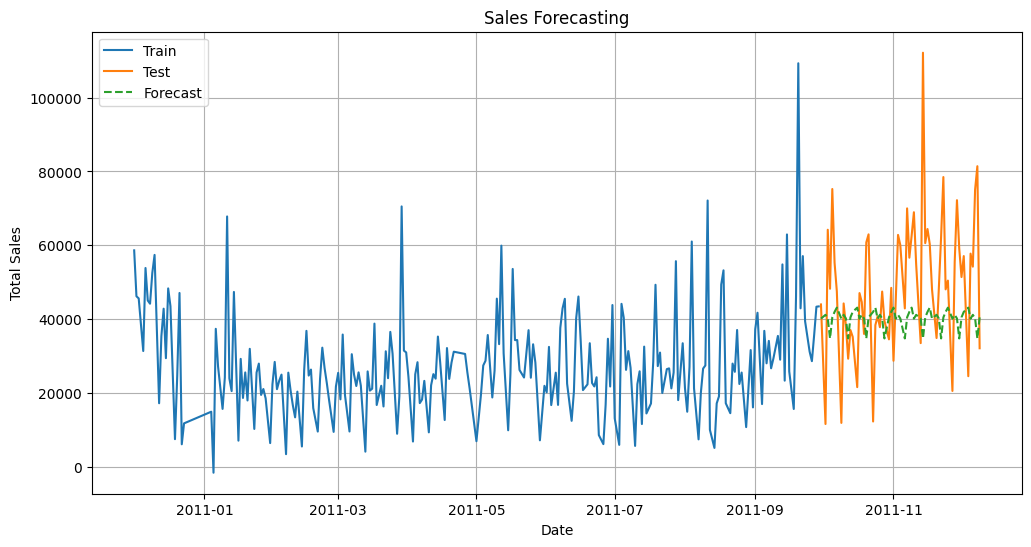

Calculated Safety Stock: 76021.77928693497
Calculated EOQ: 24150.918917826082
ABC Analysis:
  StockCode  TotalSales  CumulativePercentage Category
0       DOT   206245.48              0.021158        A
1     22423   164762.19              0.038061        A
2     47566    98302.98              0.048146        A
3    85123A    97894.50              0.058188        A
4    85099B    92356.03              0.067663        A
Calculated Reorder Point (ROP): 299740.58432955795

--- Actionable Insights ---
Safety Stock: Maintain at least 76021.78 units as a buffer.
EOQ: Order 24150.92 units per order to minimize costs.
Reorder Point: Replenish stock when inventory falls to 299740.58 units.


In [54]:
# Aggregate data at the daily level
daily_sales = data.groupby(data['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
daily_sales.columns = ['Date', 'TotalSales']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])
daily_sales.set_index('Date', inplace=True)

# 1. Demand Forecasting
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

# Holt-Winters model for demand forecasting
model = ExponentialSmoothing(train['TotalSales'], seasonal='add', seasonal_periods=7).fit()
forecast = model.forecast(len(test))

# Evaluate and plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['TotalSales'], label='Train')
plt.plot(test.index, test['TotalSales'], label='Test')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid()
plt.show()

# 2. Calculate Safety Stock
def calculate_safety_stock(daily_demand, lead_time_days, std_dev_demand):
    z_score = 1.65  # For 95% service level
    safety_stock = z_score * std_dev_demand * np.sqrt(lead_time_days)
    return safety_stock

daily_demand = daily_sales['TotalSales'].mean()
std_dev_demand = daily_sales['TotalSales'].std()
lead_time_days = 7  # Assuming 7 days lead time

safety_stock = calculate_safety_stock(daily_demand, lead_time_days, std_dev_demand)
print(f"Calculated Safety Stock: {safety_stock}")

# 3. Economic Order Quantity (EOQ)
def calculate_eoq(demand, ordering_cost, holding_cost):
    eoq = np.sqrt((2 * demand * ordering_cost) / holding_cost)
    return eoq

annual_demand = daily_demand * 365
ordering_cost = 50  # Cost of placing an order
holding_cost = 2  # Cost of holding one unit in inventory per year

eoq = calculate_eoq(annual_demand, ordering_cost, holding_cost)
print(f"Calculated EOQ: {eoq}")

# 4. ABC Analysis
item_sales = data.groupby('StockCode')['TotalSales'].sum().sort_values(ascending=False)
item_cumsum = item_sales.cumsum() / item_sales.sum()

abc_analysis = pd.DataFrame({
    'StockCode': item_sales.index,
    'TotalSales': item_sales.values,
    'CumulativePercentage': item_cumsum.values
})
abc_analysis['Category'] = pd.cut(
    abc_analysis['CumulativePercentage'],
    bins=[0, 0.8, 0.95, 1],
    labels=['A', 'B', 'C']
)
print("ABC Analysis:")
print(abc_analysis.head())

# 5. Reorder Point (ROP)
def calculate_reorder_point(lead_time_demand, safety_stock):
    reorder_point = lead_time_demand + safety_stock
    return reorder_point

lead_time_demand = daily_demand * lead_time_days
reorder_point = calculate_reorder_point(lead_time_demand, safety_stock)
print(f"Calculated Reorder Point (ROP): {reorder_point}")

# Actionable Insights
print("\n--- Actionable Insights ---")
print(f"Safety Stock: Maintain at least {safety_stock:.2f} units as a buffer.")
print(f"EOQ: Order {eoq:.2f} units per order to minimize costs.")
print(f"Reorder Point: Replenish stock when inventory falls to {reorder_point:.2f} units.")

**Advanced Demand Forecasting with XGBoost**

Mean Squared Error: 515761203.06940895
Root Mean Squared Error: 22710.376550586054


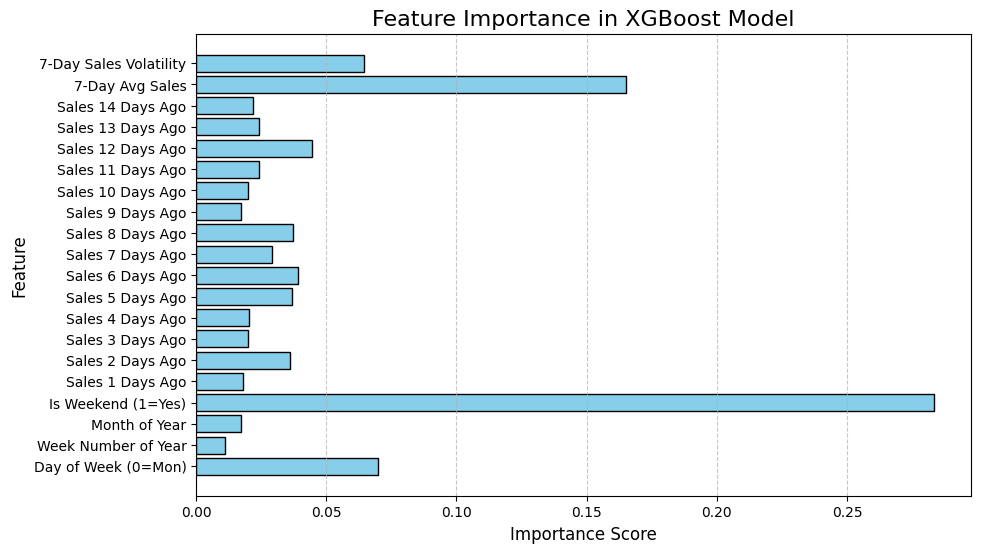

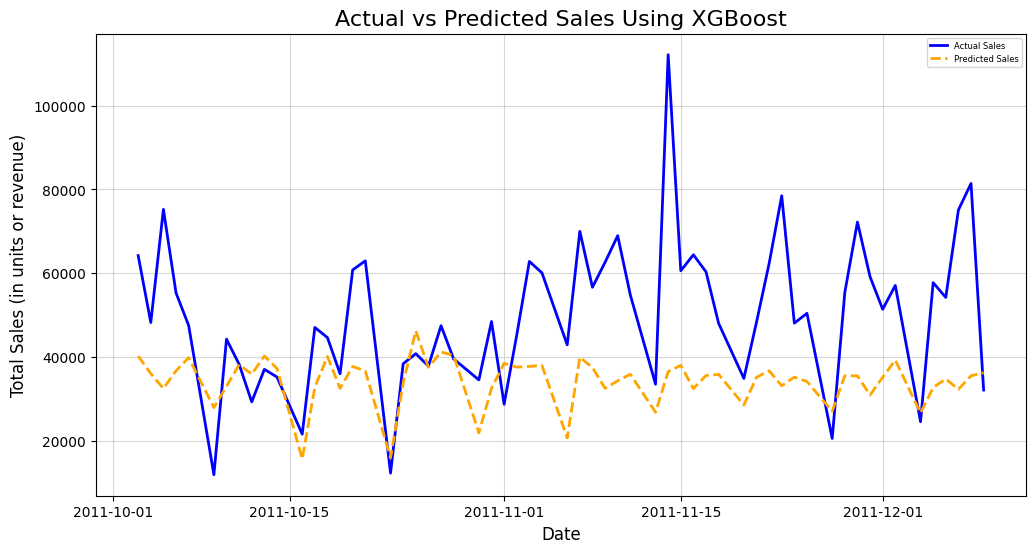

In [55]:
# Advanced Demand Forecasting with XGBoost (Human-Readable Feature Names)

# Prepare the data
daily_sales = data.groupby(data['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
daily_sales.columns = ['Date', 'TotalSales']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])
daily_sales.set_index('Date', inplace=True)

# Feature engineering with human-readable names
daily_sales['Day of Week (0=Mon)'] = daily_sales.index.dayofweek  # Day of the week (0=Monday, 6=Sunday)
daily_sales['Week Number of Year'] = daily_sales.index.isocalendar().week
daily_sales['Month of Year'] = daily_sales.index.month
daily_sales['Is Weekend (1=Yes)'] = daily_sales['Day of Week (0=Mon)'].isin([5, 6]).astype(int)

# Create lag features with human-readable names
for lag in range(1, 15):
    daily_sales[f'Sales {lag} Days Ago'] = daily_sales['TotalSales'].shift(lag)

# Create rolling window features
daily_sales['7-Day Avg Sales'] = daily_sales['TotalSales'].rolling(window=7).mean()
daily_sales['7-Day Sales Volatility'] = daily_sales['TotalSales'].rolling(window=7).std()

# Drop rows with missing values due to lagging and rolling features
daily_sales.dropna(inplace=True)

# Split data into features (X) and target (y)
X = daily_sales.drop('TotalSales', axis=1)
y = daily_sales['TotalSales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train XGBoost model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Plot feature importance with human-readable labels
plt.figure(figsize=(10, 6))
plt.barh(X.columns, xgb_model.feature_importances_, color='skyblue', edgecolor='black')
plt.title('Feature Importance in XGBoost Model', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Plot predictions vs actual values with clear labels
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Sales', color='blue', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Sales Using XGBoost', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (in units or revenue)', fontsize=12)
plt.legend(fontsize=6)
plt.grid(alpha=0.5)
plt.show()


**Inventory Turnover Rate**

In [56]:
# Calculate Inventory Turnover Rate
# Assumes average inventory over a month
average_inventory = daily_sales['TotalSales'].mean() * 30  # Assume a 30-day month
total_sales = daily_sales['TotalSales'].sum()

# Turnover Rate Formula
turnover_rate = total_sales / average_inventory
print(f"Inventory Turnover Rate: {turnover_rate:.2f}")


Inventory Turnover Rate: 9.70


**Stockout Rate**

In [57]:
# Calculate Stockout Rate
daily_sales_mean = daily_sales['TotalSales'].mean()
initial_inventory = safety_stock + (daily_sales_mean * 7)
daily_sales['Inventory'] = initial_inventory - daily_sales['TotalSales'].cumsum()

# Identify Stockouts
stockouts = daily_sales['Inventory'] < 0
stockout_rate = stockouts.sum() / len(daily_sales) * 100
print(f"Stockout Rate: {stockout_rate:.2f}%")


Stockout Rate: 95.88%


**Safety Stock Adjustment**

In [58]:
# Simulating Lead Time Variability and Safety Stock Adjustment
import numpy as np

# Simulate lead times in days (normally distributed)
np.random.seed(42)
lead_times = np.random.normal(loc=7, scale=2, size=30)  # Mean = 7 days, Std Dev = 2 days

# Calculate expected safety stock considering lead time variability
average_daily_demand = daily_sales['TotalSales'].mean()
safety_stock = average_daily_demand * np.std(lead_times)
print(f"Safety Stock with Lead Time Variability: {safety_stock:.2f}")


Safety Stock with Lead Time Variability: 55583.87


**Real-time or live inventory updates**

In [59]:
from datetime import datetime, timedelta
import time
# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Group sales data by hour
hourly_sales = data.groupby(data['InvoiceDate'].dt.strftime('%Y-%m-%d %H:00:00'))['Quantity'].sum().reset_index()
hourly_sales.columns = ['timestamp', 'quantity_sold']

# Convert to list of dictionaries for real-time simulation
real_time_sales = hourly_sales.to_dict(orient='records')

# Display sample of the dynamic data
print(real_time_sales[:10])  # Preview first 10 entries
daily_sales_mean = daily_sales['TotalSales'].mean()
initial_inventory = safety_stock + (daily_sales_mean * 7)
daily_sales['Inventory'] = initial_inventory - daily_sales['TotalSales'].cumsum()
start_time = datetime.now()
# Real-time inventory update

for sale in real_time_sales:
    current_time = datetime.now()
    elapsed_time = current_time - start_time

    # Stop simulation after 1 minute
    if elapsed_time > timedelta(seconds=100):
        print("Simulation stopped after 3 seconds")
        break

    timestamp = sale["timestamp"]
    quantity_sold = sale["quantity_sold"]
    initial_inventory -= quantity_sold

    print(f"Timestamp: {timestamp}, Quantity Sold: {quantity_sold}, Remaining Inventory: {initial_inventory}")
    time.sleep(1)



[{'timestamp': '2010-12-01 08:00:00', 'quantity_sold': 602}, {'timestamp': '2010-12-01 09:00:00', 'quantity_sold': 3259}, {'timestamp': '2010-12-01 10:00:00', 'quantity_sold': 2794}, {'timestamp': '2010-12-01 11:00:00', 'quantity_sold': 2356}, {'timestamp': '2010-12-01 12:00:00', 'quantity_sold': 4161}, {'timestamp': '2010-12-01 13:00:00', 'quantity_sold': 3240}, {'timestamp': '2010-12-01 14:00:00', 'quantity_sold': 2486}, {'timestamp': '2010-12-01 15:00:00', 'quantity_sold': 1876}, {'timestamp': '2010-12-01 16:00:00', 'quantity_sold': 4321}, {'timestamp': '2010-12-01 17:00:00', 'quantity_sold': 1719}]
Timestamp: 2010-12-01 08:00:00, Quantity Sold: 602, Remaining Inventory: 274835.1051050516
Timestamp: 2010-12-01 09:00:00, Quantity Sold: 3259, Remaining Inventory: 271576.1051050516
Timestamp: 2010-12-01 10:00:00, Quantity Sold: 2794, Remaining Inventory: 268782.1051050516
Timestamp: 2010-12-01 11:00:00, Quantity Sold: 2356, Remaining Inventory: 266426.1051050516
Timestamp: 2010-12-01 1